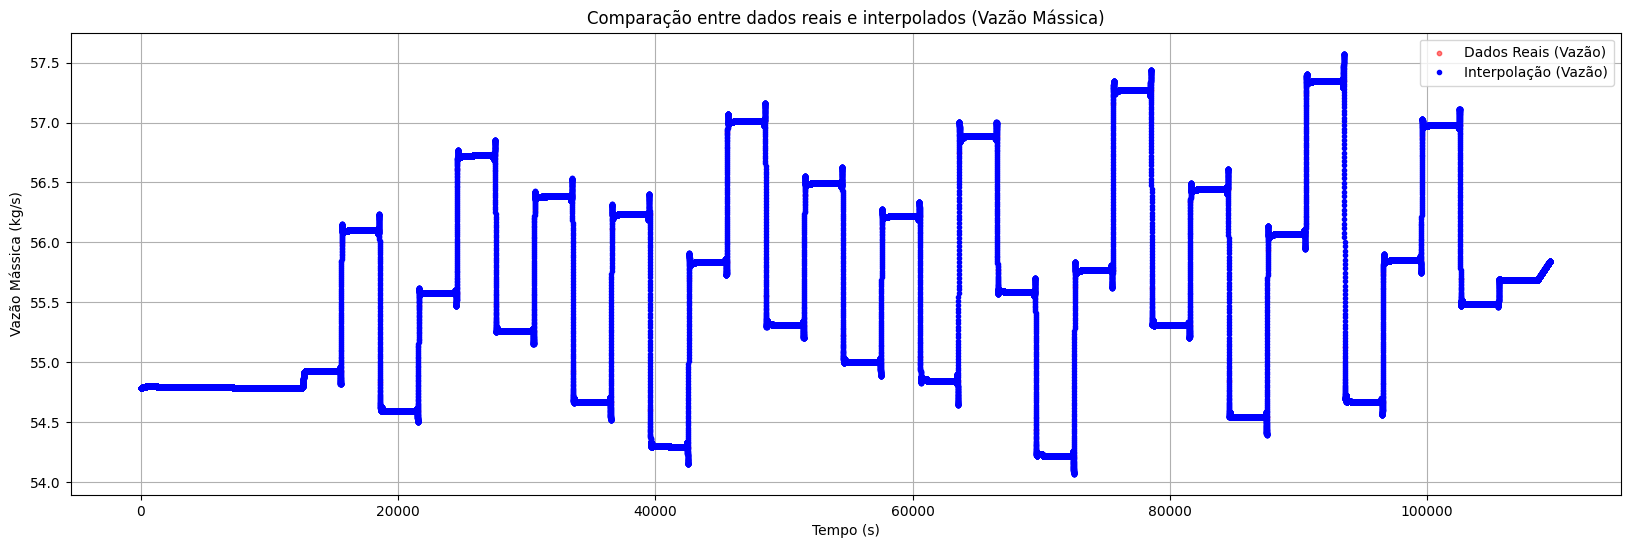

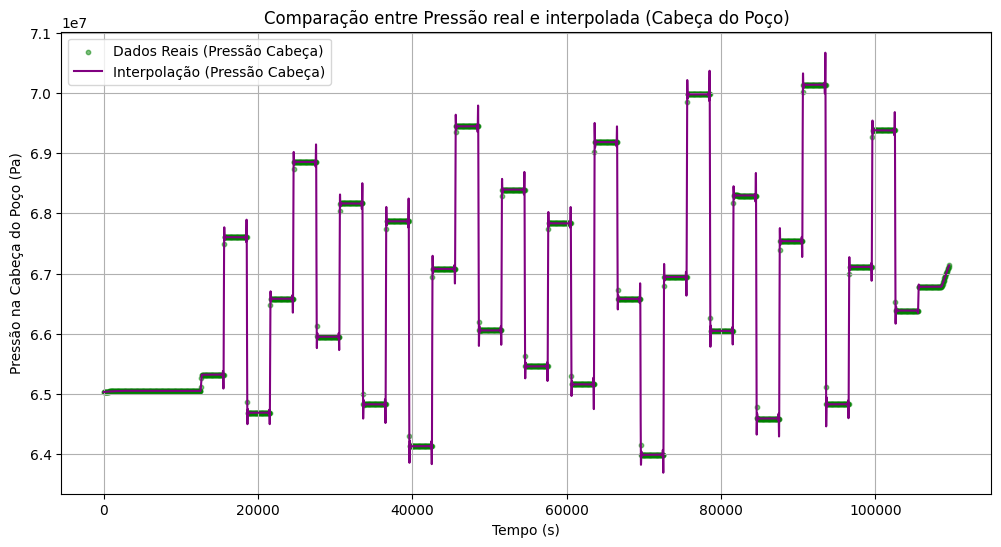

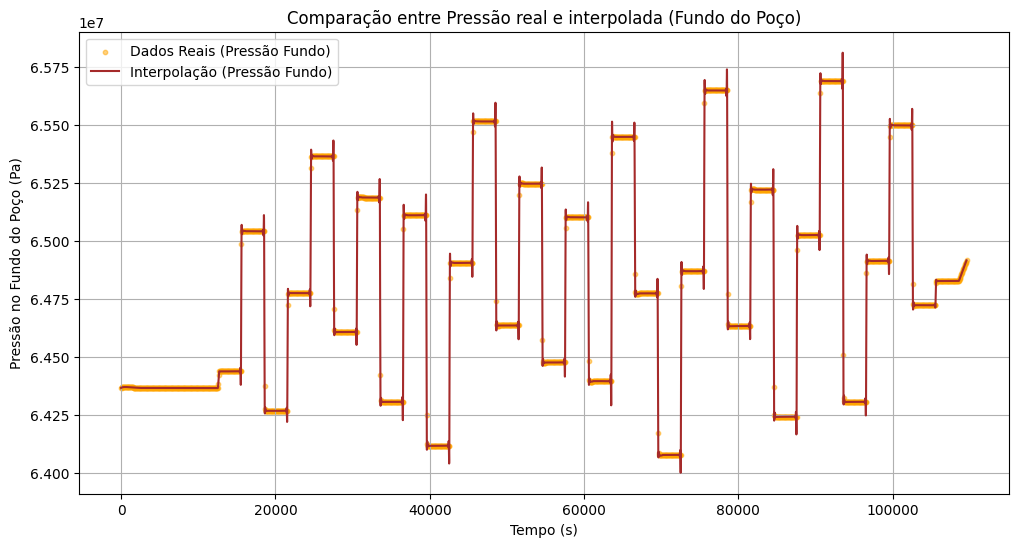

123999
1827
123999
[6.0e+00 6.0e+00 6.0e+00 ... 9.5e+08 9.5e+08 8.5e+08] [80. 80. 80. ... 88. 88. 87.]


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import torch
import torch.nn as nn
import torch.optim as optim
import time
from interpolate import *


In [2]:
def normalize(Mat_ref, Mat_dados):
    max_value = Mat_ref.max()
    min_value = Mat_ref.min()
    return 2 * (Mat_dados - min_value) / (max_value - min_value) - 1

def des_normalize(Mat_ref, Mat_dados):
    max_value = Mat_ref.max()
    min_value = Mat_ref.min()
    return (Mat_dados + 1) * (max_value - min_value) / 2 + min_value

In [3]:
P_node1.reshape(-1, 1)
T_transiente.reshape(-1, 1)
ref3 = P_node1
ref4 = T_transiente


In [4]:

mass_flow_rate = np.array(mass_flow_rate)
pressure_head = np.array(pressure_head)
pressure_bottom = np.array(pressure_bottom)

mass_flow_rate = mass_flow_rate.reshape(-1, 1)
pressure_head = pressure_head.reshape(-1, 1)
pressure_bottom = pressure_bottom.reshape(-1, 1)


ref = mass_flow_rate
ref2 = pressure_head
ref5 = pressure_bottom

mass_flow_rate = normalize(mass_flow_rate, ref)
pressão = normalize(pressure_head, ref2)
pressão_bottom = normalize(pressure_bottom, ref5)
P_node1 = normalize(P_node1, ref3)
T_transiente = normalize(T_transiente, ref4)

In [5]:
print(mass_flow_rate.shape)

(123999, 1)


In [6]:
from sklearn.model_selection import train_test_split
X = np.column_stack((mass_flow_rate[:-1], pressão[:-1], P_node1[:-1], T_transiente[:-1]))
y = pressão_bottom[1:]
print(X.shape)
print(y.shape)


(123998, 4)
(123998, 1)


In [7]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
_ ="fdf"

In [8]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i : i + timesteps])  # Janela de entrada
        y_seq.append(y[i + timesteps])      # Próximo valor de fluxo mássico (previsão)
    return np.array(X_seq), np.array(y_seq)

# Exemplo para prever 3 passos à frente
X_seq, y_seq = create_sequences(X, y, timesteps=16)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



print(y_train_tensor.shape)
# Ensure target tensors have the correct shape
y_train = y_train_tensor.unsqueeze(-1)  # Shape: [4491, 1]
y_test = y_test_tensor.unsqueeze(-1)    # Shape: [4492, 1]

# Print shapes for verification
print(X_train_tensor.shape)  # torch.Size([4491, 16, 2])
print(y_train.shape)         # torch.Size([4491, 1])
print(X_test_tensor.shape)   # torch.Size([4492, 16, 2])
print(y_test.shape)          # torch.Size([4492, 1])

torch.Size([111583, 1])
torch.Size([111583, 16, 4])
torch.Size([111583, 1, 1])
torch.Size([12399, 16, 4])
torch.Size([12399, 1, 1])


In [9]:
print(X_test)


[[[ 0.01804964 -0.02002071 -1.          0.6       ]
  [ 0.01804964 -0.0200207  -1.          0.6       ]
  [ 0.01804964 -0.0200207  -1.          0.6       ]
  ...
  [ 0.01804963 -0.02002063 -1.          0.6       ]
  [ 0.01804963 -0.02002062 -1.          0.6       ]
  [ 0.01804964 -0.02002062 -1.          0.6       ]]

 [[ 0.01804964 -0.0200207  -1.          0.6       ]
  [ 0.01804964 -0.0200207  -1.          0.6       ]
  [ 0.01804964 -0.02002069 -1.          0.6       ]
  ...
  [ 0.01804963 -0.02002062 -1.          0.6       ]
  [ 0.01804964 -0.02002062 -1.          0.6       ]
  [ 0.01804964 -0.02002061 -1.          0.6       ]]

 [[ 0.01804964 -0.0200207  -1.          0.6       ]
  [ 0.01804964 -0.02002069 -1.          0.6       ]
  [ 0.01804964 -0.02002068 -1.          0.6       ]
  ...
  [ 0.01804964 -0.02002062 -1.          0.6       ]
  [ 0.01804964 -0.02002061 -1.          0.6       ]
  [ 0.01804964 -0.02002061 -1.          0.6       ]]

 ...

 [[ 0.01106161 -0.01421412  1.    

In [10]:
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate, n_steps_ahead):
        super(LSTMModel, self).__init__()
        self.n_steps_ahead = n_steps_ahead
        
        # Camada LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout_rate)
        
        # Camadas densas para prever múltiplos passos
        self.dense_layers = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Linear(8, 1)  # Saída com n_steps_ahead dimensões
        )
    
    def forward(self, x):
        # Passar pela LSTM
        lstm_out, _ = self.lstm(x)
        
        # Pegar apenas a saída do último time step
        last_out = lstm_out[:, -1, :]
        
        # Passar pelas camadas densas
        out = self.dense_layers(last_out)
        return out


In [12]:
seed = 42
torch.manual_seed(seed)
model1 = LSTMModel(input_dim=4, hidden_dim=10, output_dim=1, dropout_rate=0.2, n_steps_ahead=3)

c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [13]:

# Definindo pesos e critério
criterion = nn.MSELoss() #CustomMSELoss(weights)  # Substitua por seu critério personalizado
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Para armazenar as perdas de treino e validação
train_losses = [1]
val_losses = []
best_loss = float('inf')
patience = 0

# Training loop
num_epochs = 700
best_loss = float('inf')
best_train_loss = float('inf')
patience = 0
early_stop_patience = 50000
train_loss = 0.0
for epoch in range(num_epochs):
    model1.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model1(inputs)
        
        targets = targets.squeeze(-1)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation loop
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model1(inputs)
            targets = targets.squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    # Print losses
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # Early stopping
    if val_loss < best_loss:# and train_loss <=  best_train_loss:
        print("Saving model.")
        best_loss = val_loss
        best_train_loss = train_loss
        torch.save(model1.state_dict(), 'best_model.pth')
        patience = 0

    
    else:
        patience += 1
        if patience >= early_stop_patience:
            print(best_loss, best_train_loss)
            print("Early stopping...")
            break

Epoch 1/700, Train Loss: 0.011639, Val Loss: 0.010442
Saving model.
Epoch 2/700, Train Loss: 0.000875, Val Loss: 0.008461
Saving model.
Epoch 3/700, Train Loss: 0.000543, Val Loss: 0.007468
Saving model.
Epoch 4/700, Train Loss: 0.000384, Val Loss: 0.007000
Saving model.
Epoch 5/700, Train Loss: 0.000324, Val Loss: 0.007020
Epoch 6/700, Train Loss: 0.000273, Val Loss: 0.006788
Saving model.
Epoch 7/700, Train Loss: 0.000229, Val Loss: 0.005858
Saving model.
Epoch 8/700, Train Loss: 0.000207, Val Loss: 0.005291
Saving model.
Epoch 9/700, Train Loss: 0.000185, Val Loss: 0.004602
Saving model.
Epoch 10/700, Train Loss: 0.000169, Val Loss: 0.003481
Saving model.
Epoch 11/700, Train Loss: 0.000148, Val Loss: 0.001693
Saving model.
Epoch 12/700, Train Loss: 0.000134, Val Loss: 0.000549
Saving model.
Epoch 13/700, Train Loss: 0.000121, Val Loss: 0.000146
Saving model.
Epoch 14/700, Train Loss: 0.000114, Val Loss: 0.000156
Epoch 15/700, Train Loss: 0.000107, Val Loss: 0.000177
Epoch 16/700, Tr

In [14]:
X_test_tensor.shape

torch.Size([12399, 16, 4])

In [15]:
import numpy as np

# Save LSTM weights (input, hidden, biases)
lstm_weight_ih = model1.lstm.weight_ih_l0.detach().numpy()  # Input-hidden weights
lstm_weight_hh = model1.lstm.weight_hh_l0.detach().numpy()  # Hidden-hidden weights
lstm_bias = model1.lstm.bias_ih_l0.detach().numpy() + model1.lstm.bias_hh_l0.detach().numpy()  # Sum biases

# Save Dense layer weights
dense1_weight = model1.dense_layers[0].weight.detach().numpy()
dense1_bias = model1.dense_layers[0].bias.detach().numpy()
dense2_weight = model1.dense_layers[2].weight.detach().numpy()
dense2_bias = model1.dense_layers[2].bias.detach().numpy()
dense3_weight = model1.dense_layers[4].weight.detach().numpy()
dense3_bias = model1.dense_layers[4].bias.detach().numpy()

# Quantize to int8 (scale to [-128, 127])
def quantize(arr):
    scale = np.max(np.abs(arr)) / 127
    return (arr / scale).astype(np.float16), scale

lstm_weight_ih_int8, scale_ih = quantize(lstm_weight_ih)
lstm_weight_hh_int8, scale_hh = quantize(lstm_weight_hh)
lstm_bias_int8, scale_bias = quantize(lstm_bias)
dense1_weight_int8, scale_dense1 = quantize(dense1_weight)
dense1_bias_int8, scale_dense1_bias = quantize(dense1_bias)
dense2_weight_int8, scale_dense2 = quantize(dense2_weight)
dense2_bias_int8, scale_dense2_bias = quantize(dense2_bias)
dense3_weight_int8, scale_dense3 = quantize(dense3_weight)
dense3_bias_int8, scale_dense3_bias = quantize(dense3_bias)
# Save scales for dequantization

# Save as CSV or C header
np.savetxt("lstm_weight_ih_int8.csv", lstm_weight_ih_int8, delimiter=",", fmt="%d")
np.savetxt("lstm_weight_hh_int8.csv", lstm_weight_hh_int8, delimiter=",", fmt="%d")
np.savetxt("lstm_bias_int8.csv", lstm_bias_int8, delimiter=",", fmt="%d")
np.savetxt("dense1_weight_int8.csv", dense1_weight, delimiter=",", fmt="%d")
np.savetxt("dense1_bias_int8.csv", dense1_bias_int8, delimiter=",", fmt="%d")
np.savetxt("dense2_weight_int8.csv", dense2_weight, delimiter=",", fmt="%d")
np.savetxt("dense2_bias_int8.csv", dense2_bias_int8, delimiter=",", fmt="%d")
np.savetxt("dense3_weight_int8.csv", dense3_weight, delimiter=",", fmt="%d")
np.savetxt("dense3_bias_int8.csv", dense3_bias_int8, delimiter=",", fmt="%d")


In [16]:

# Função para salvar CSV em float16
def save_csv_float16(filename, data):
    np.savetxt(filename, data.astype(np.float16), delimiter=",", fmt="%.6e")  # Salva em float16

# Salvar os pesos e vieses do LSTM
lstm_weight_ih = model1.lstm.weight_ih_l0.detach().numpy().astype(np.float16)
lstm_weight_hh = model1.lstm.weight_hh_l0.detach().numpy().astype(np.float16)
lstm_bias = (model1.lstm.bias_ih_l0.detach().numpy() + model1.lstm.bias_hh_l0.detach().numpy()).astype(np.float16)

# Salvar os pesos e vieses das camadas densas
dense1_weight = model1.dense_layers[0].weight.detach().numpy().astype(np.float16)
dense1_bias = model1.dense_layers[0].bias.detach().numpy().astype(np.float16)
dense2_weight = model1.dense_layers[2].weight.detach().numpy().astype(np.float16)
dense2_bias = model1.dense_layers[2].bias.detach().numpy().astype(np.float16)
dense3_weight = model1.dense_layers[4].weight.detach().numpy().astype(np.float16)
dense3_bias = model1.dense_layers[4].bias.detach().numpy().astype(np.float16)

# Salvando os pesos e vieses em CSV (float16)
save_csv_float16("lstm_weight_ih_f16.csv", lstm_weight_ih)
save_csv_float16("lstm_weight_hh_f16.csv", lstm_weight_hh)
save_csv_float16("lstm_bias_f16.csv", lstm_bias)
save_csv_float16("dense1_weight_f16.csv", dense1_weight)
save_csv_float16("dense1_bias_f16.csv", dense1_bias)
save_csv_float16("dense2_weight_f16.csv", dense2_weight)
save_csv_float16("dense2_bias_f16.csv", dense2_bias)
save_csv_float16("dense3_weight_f16.csv", dense3_weight)
save_csv_float16("dense3_bias_f16.csv", dense3_bias)


In [17]:
# Realizar a predição
with torch.no_grad():  # Desativa o cálculo do gradiente para predição
    y_pred = model1(X_test_tensor)  # Previsão no conjunto de teste

print(y_pred)

tensor([[0.0085],
        [0.0085],
        [0.0085],
        ...,
        [0.0374],
        [0.0375],
        [0.0376]])


In [18]:
A = y_test.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)
print(A.shape)
print(y_pred.shape)



torch.Size([12399, 1])
torch.Size([12399, 1])


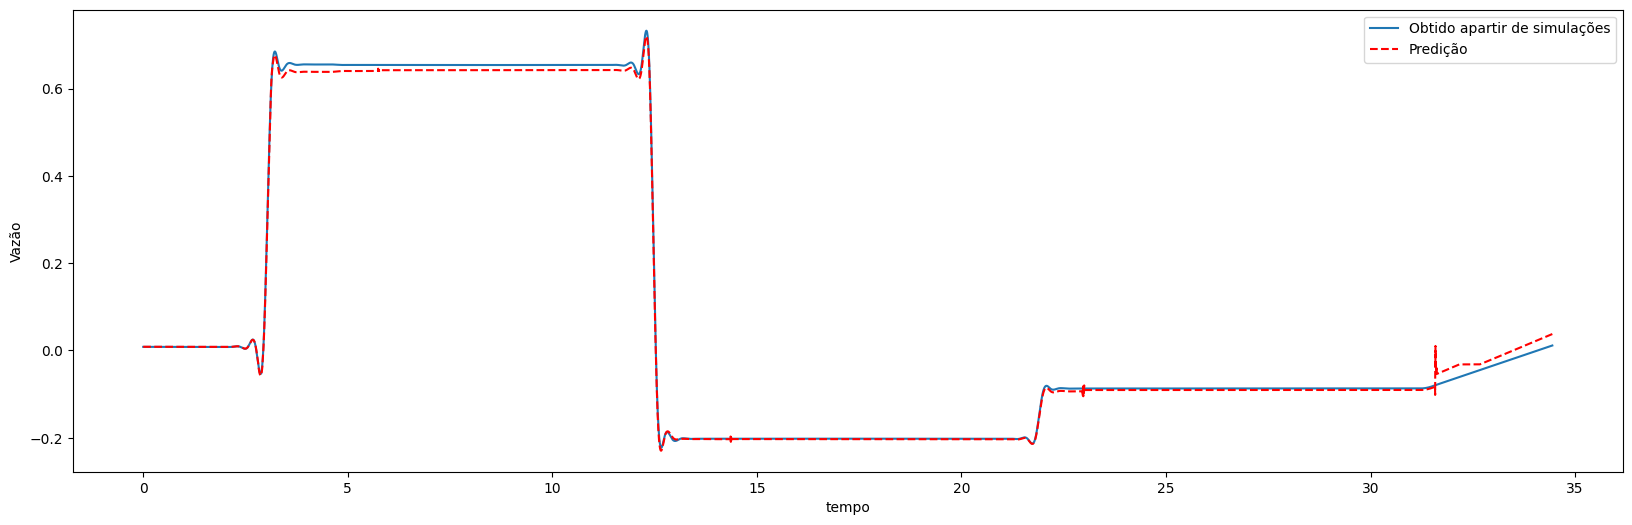

tensor([[[0.0082]],

        [[0.0082]],

        [[0.0082]],

        ...,

        [[0.0112]],

        [[0.0113]],

        [[0.0114]]]) sss
tensor([[0.0085],
        [0.0085],
        [0.0085],
        ...,
        [0.0374],
        [0.0375],
        [0.0376]]) sss


In [19]:
tempo_seg = torch.linspace(0, 12399, steps=12399)  # Simulando 37190 pontos
tempo_min = tempo_seg / 360
# Plotar os resultados
plt.figure(figsize=(20, 6))
plt.plot(tempo_min,A, label="Obtido apartir de simulações")
plt.plot(tempo_min,y_pred, label="Predição", color='red', linestyle='--')
plt.xlabel("tempo")
plt.ylabel("Vazão")
plt.title("")
plt.legend()
plt.show()
print(y_test,"sss")
print(y_pred,"sss")

